### Prompt Template Classes
- Purpose: Provide a mechanism to construct prompts for models. Prompts come in varying shapes and sizes to suit different business needs. Prompt template classes address all these needs and help produce a Prompt Value class that's used as a prompt to models.
1. Remember from the PromptValue parameter that's input to all model classes
2. This session is all about generating that at runtime in a scalable and flexible way to address diverse business needs.
3. Product `PromptValue` from `PromptTemplate`
4. The classes that make up prompts module:
5. https://techblogs.cloudlex.com/langchain-iii-prompts-2df826c0ec3d#a487
6. For chat applications we use `ChatPromptTemplate` the concrete derived class from `BaseChatPromptTemplate`
7. If we wish to use f-strings in our prompt template then we use a concrete derived class of `StringPromptTemplate`

### Prompt Value Classes
- Purpose: Represent the value returned by a Prompt Template when its invoked.
1. Represents the actual prompt that sent to the model
2. Is generated at runtime when the prompt template is invoked
3. This is the class hierarchy: https://techblogs.cloudlex.com/langchain-iii-prompts-2df826c0ec3d#ee36

### Message Prompt Template Classes
1. Prompts employ messages prompt templates to create and manipulate prompt values at runtime
2. Here are the classes: https://techblogs.cloudlex.com/langchain-iii-prompts-2df826c0ec3d#ea75

### Message Classes
1. These represent the messages themselves.
2. They are produced by prompt message templates
3. Support for chunking large messages is in these set of classes.
4. Here are the classes: https://techblogs.cloudlex.com/langchain-iii-prompts-2df826c0ec3d#e750


### NOTE
1. The names of the classes in this module can be rather confusing.
2. A Prompt is made up of messages
3. A class whose name contains *MessagePromptTemplate* usually refers to template for the messages that make up the prompt
4. A class whose name contains *PromptTemplate* is the template of the overall prompt.
5. Check this diagram: https://techblogs.cloudlex.com/langchain-iii-prompts-2df826c0ec3d#a487

Prompt Template Classes -> Prompt Value
Message Prompt Template Classes -> Messages

In [2]:
import os
import configparser
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage

# set up config parser
config = configparser.ConfigParser()
config.read("../config.ini")  # holds secrets and keys


# load Groq config
groq = config["groq"]
os.environ['GROQ_API_KEY'] = groq.get('GROQ_API_KEY')

# select the model.
model = ChatGroq(model="llama3-8b-8192")

print('setup done successfully')

# Basic Message Prompt Template
from langchain_core.prompts.chat import ChatMessagePromptTemplate

# This is the typical factory method
# Best is to check source code: https://github.com/langchain-ai/langchain/blob/master/libs/core/langchain_core/prompts/chat.py#L299
chatMessagePrompt = ChatMessagePromptTemplate.from_template(
    template= "Please give me flight options for {from_city} to {to_city}",
    role="travel agent"
)

# In the above role is required.

print(f"The type of Prompt Message Template is \n\t{type(chatMessagePrompt)}")

# Use the prompt message template to generate the message by providing values for all the replacement variables.
baseMessage = chatMessagePrompt.format(from_city="New Delhi", to_city="Mumbai", role="travel agent")

print(
    f"The type of message is: \n\t{type(baseMessage)}, \n\tand its __repr__ value is:  {baseMessage.__repr__()}"
)  

setup done successfully
The type of Prompt Message Template is 
	<class 'langchain_core.prompts.chat.ChatMessagePromptTemplate'>
The type of message is: 
	<class 'langchain_core.messages.chat.ChatMessage'>, 
	and its __repr__ value is:  ChatMessage(content='Please give me flight options for New Delhi to Mumbai', additional_kwargs={}, response_metadata={}, role='travel agent')


1. Lets try sending a system and human message to the model and get the response

In [3]:
# Create individual messages
sysMessage = SystemMessage("You are a chat bot who is an expert in political science")
humanMessage = HumanMessage(content="What is the capital of India?")

response = model.invoke([sysMessage, humanMessage])
print(response.content)

That's an easy one! The capital of India is New Delhi.


In [4]:
# Same example with a Message Prompt Template.

from langchain_core.prompts.chat import (SystemMessagePromptTemplate, HumanMessagePromptTemplate)

sysMessage = SystemMessagePromptTemplate.from_template(template='You are a chat bot who is an expert in political science')
humanMessage = HumanMessagePromptTemplate.from_template(template='What is the capital of {country}')


response = model.invoke([sysMessage.format(), humanMessage.format(country='USA')])

print(response.content)



The capital of the United States of America is Washington, D.C. (short for District of Columbia).


## Chat Prompt Template - using a list of string.
This represents a conversation context of a chat. The conversation can contain many back and forth messages. This template threrefore has a colleciton of messages. We can supply the messages using tuples or creating message objects using Message Prompt Template.

We can provide any of the following type of messages:
1. system - Like instructions or a note or context. Anything that we as the developer want the model to use for understanding its role, its tasks and expectations and give sufficient context.
2. human - Encapsulates any responses or messages by the user
3. ai - Encapsulates any responses by the model. 
4. placeholder - A placeholder where the prompt will receive an optional list of messages at run time.
5. assistant - Gets created as an AI message internally

Apart from this there are message templates to represent messages to tools and their responses that go back to model. We shall cover them when we get to tools.

Below is an example of creating a chat prompt using string.

In [5]:
from langchain_core.prompts import ChatPromptTemplate

template = ChatPromptTemplate(
    [
        ("system", "You are a helpful AI bot. Your name is {name}."),
        ("human", "Hello, how are you doing?"),
        ("ai", "I'm doing well, thanks!"),
        ("human", "{user_input}")
    ]
)

print('Template Messages: ',template.messages.__repr__())
print('Template Object: ', template.__repr__())


promptValue = template.invoke(input={"name":"Arun", "user_input":"How is the weather today?"})
print('Prompt Value: ',promptValue.__repr__())

Template Messages:  [SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['name'], input_types={}, partial_variables={}, template='You are a helpful AI bot. Your name is {name}.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='Hello, how are you doing?'), additional_kwargs={}), AIMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="I'm doing well, thanks!"), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['user_input'], input_types={}, partial_variables={}, template='{user_input}'), additional_kwargs={})]
Template Object:  ChatPromptTemplate(input_variables=['name', 'user_input'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['name'], input_types={}, partial_variables={}, template='You are a helpful AI bot. Your n

## ChatPrompt Template using objects

Lets try and create the same prompt using Message Prompt Templates instead.


In [6]:
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, AIMessagePromptTemplate, ChatPromptTemplate, PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

# We use message prompt template as we have a replacement variable.
systemMessage = SystemMessagePromptTemplate.from_template("You are a helpful AI bot. Your name is {name}.")

# No need to use message prompt template as no replacement variable.
humanMessage1 = HumanMessage("Hello, how are you doing?")

aimessage = AIMessage("I'm doing well, thanks!")

humanMessage2 = HumanMessagePromptTemplate.from_template("{user_input}")

template = ChatPromptTemplate.from_messages([
    systemMessage, humanMessage1, aimessage, humanMessage2
])

promptValue = template.invoke(input={"name":"Arun", "user_input":"How is the weather today?"})

print('Prompt Value: ', promptValue.__repr__())

model.invoke(promptValue)

Prompt Value:  ChatPromptValue(messages=[SystemMessage(content='You are a helpful AI bot. Your name is Arun.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Hello, how are you doing?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm doing well, thanks!", additional_kwargs={}, response_metadata={}), HumanMessage(content='How is the weather today?', additional_kwargs={}, response_metadata={})])


AIMessage(content="I'm just an AI, I don't have the capability to perceive or access real-time weather information. I exist solely in the digital realm and don't have a physical presence. However, I can provide you with general information about the weather or help you find out the weather forecast for your location if you'd like!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 58, 'total_tokens': 123, 'completion_time': 0.054166667, 'prompt_time': 0.008182442, 'queue_time': 0.0054390770000000005, 'total_time': 0.062349109}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'stop', 'logprobs': None}, id='run-4d2294e4-0e3b-4173-a008-eec00afe60a2-0', usage_metadata={'input_tokens': 58, 'output_tokens': 65, 'total_tokens': 123})

## Chat Prompt Template with image
Lets say you want to send an iamge to a Model along with a question associated with the image

Image Prompt ImagePromptTemplate(input_variables=['imageName'], input_types={}, partial_variables={}, template={'url': 'http://yourdomain.com/{imageName}', 'detail': 'low'})
Prompt Value ImagePromptValue(image_url={'detail': 'low', 'url': 'http://yourdomain.com/good_pic.jpeg'})
ImageURL object {'detail': 'low', 'url': 'http://yourdomain.com/good_pic.jpeg'}
Human Message1 HumanMessagePromptTemplate(prompt=[ImagePromptTemplate(input_variables=['imageName'], input_types={}, partial_variables={}, template={'url': 'http://yourdomain.com/{imageName}', 'detail': 'low'})], additional_kwargs={})
Human Message2 HumanMessage(content='Describe this image in brief', additional_kwargs={}, response_metadata={})
Chat prompt:  ChatPromptTemplate(input_variables=['imageName'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=[ImagePromptTemplate(input_variables=['imageName'], input_types={}, partial_variables={}, template={'url': 'http://yourdomain.com/{imageName}', 'det
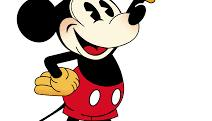

In [ ]:
from langchain_core.prompts.image import ImagePromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate
from langchain_core.messages import HumanMessage


# Lets create the Image Prompt Template
imagePrompt = ImagePromptTemplate(input_variables=["imageName"], template={"url":"http://yourdomain.com/{imageName}", "detail":"low"})

# Just to check we are doing this right - lets invoke and see if the variables are replaced
promptValue = imagePrompt.invoke(input={"imageName":"good_pic.jpeg"})
print('Image Prompt',imagePrompt.__repr__())
print('Prompt Value', promptValue.__repr__())
print("ImageURL object", promptValue.image_url)


# Now lets wrap our Image Prompt Template within our Human Message Prompt Template
humanMessage1 = HumanMessagePromptTemplate(prompt=[imagePrompt])
print('Human Message1', humanMessage1.__repr__())

# And since there is no replacement variable we create the message directly.
humanMessage2 = HumanMessage("Describe this image in brief")
print('Human Message2', humanMessage2.__repr__())

# Now we can use both these in our Chat Prompt Template
chatPrompt = ChatPromptTemplate.from_messages([
    humanMessage1, humanMessage2
])
print('Chat prompt: ', chatPrompt.__repr__())

# And invoke will substitute the values and prepare the prompt to be sent to model
promptValue = chatPrompt.invoke(input={"imageName":"data:image/webp;base64,UklGRvRGAABXRUJQVlA4TOhGAAAv0wAeAE04bNtGkiwn947Tf8H7zJYQ0f8JAJ3a1e5uifL5Bfb7gJTcsGQXuAtnEepKkpeTBhxibrZke/yGtfj71ml3AwPFHtDvlNiXhIDIOw45lWRvUCSvfG3YC8x4vYG1F0hNkniLtZLEjp+ozEwmeUACCMx6gOt7C7eRJElKxklIxPlvFSa0Cfw/KxHbZwIcR5IcOYHBikZjRd8dtbX/fxBtghYtrckFAbm1JEXS0/hvFc9p1BaM/sKJmXdT/Z8ATOr4BBgERXDl+Q3zKncBUAA7QORGFM2Rdx55h78DCCgj3zSAeosOlY6C3pFvADOq/ZZadt2ilg3ggR0MTwYMAIROsbMzjEaM+BNQk40NFGdMacSIpw0iR2EARFEUobeMW7j+e++Yo3NEW2g8c28AxF4+3BWJRFFB0IEzurGsxCJ/dEwPYkRUYNWqSPszjVirI9dLML2ZRhY1IAGSnGU6mpjOphuDqINiIskHSZAnudKJqANcDcMXagaDtpEcZRp/0F/uIETEBIAEkp0ndsa3JMFHTPgDkM8mPmoSngm/BEmTXkAySbY2Ccf2YzPnfqbJjTRbC9ZRnhuAr3RNu534sXW7AKYrl2jWrl3PZL9sHEs0HceUa9uW20b7fsp9k0RNK/9oKg+3wh0ALEBr/Y8xxUiSFMmWZ/U+BgWe/srx+wz7upJiI0mOJMkysnaP6y8pedIdFRNAefs/Q5L0iUgV2zzOybjNbWZt67zP/gd7N2+2bRsn23uybVZnZWZEZnzXW13P0/eImADL+/8fkiS9vz9ERGZWVrYxNm+2bZ1s3GzbM3+Abdu2bc+sx+mI+EX8vovqPfXTZ4ltI0mSxMjq3nPkXDj/nfqvpzMkuY0kSRLdM7JnP87/P9l7RJrHBHi0tk2R3GjbrojISKysruru6m4xg0EyyhppmZkZRcNkHCYzg/zw8xiXFzMzM7OtEY4YWtTFlZUcsAPPBviOZFu1bdu2IqVcam299zF5oy5bDpaDGf7oa6u3BcCDc80xRmu1lpyTb9u2Tdu2ti3lXGprvfcx5pzb5tljm5fh57mDff6c+Sps27aNbdt7z7XGmgMdrZZSIvzWtq3atm1bKZdSa2sdxpibmRlkZmbe24otbm07sFV2gcStb3k7sLfIzDDDHNB7b721WrIbHmtbUmTbtq1m4B4Jg+acmxaDAJtBiS3jFocVYGbegxLc3cw8R7at2rZtW55zbWOMtdZm3kEOb5G2hFuDLckWgBkH9VZKBIVt285G+oTu942Tuh1zdz/btm3btm3btm3b5szaO4u2oyrOC0vbthmSbX3xhVPlxurV7m3b1nBfe3zMX2D7jM7oTM9vsW1roXe7uouJiAz41rbNkLRt2/Z9PyIi0bxu277HbHOabE2UbfsevOzr6u7qqsyI4zgiCs4q7/mQFW0cJ5zNKLvPbk6rDJoIX0w8fuTYSpoy8d1mlF0z5/WXPWecHNQst7r3uCSp0bncbu/qHVyGHHR2zWNhGk6WwOY2T0lKZDM0rX2pFpVWdj4StRPNpo4De7W79sq4LRycNJUpU8/RrnqW43n1mlPz2efmlVmulMLiDACQIBgvgPJSHkFw/8uaS4lhC14GLDVz+RfQoCIcOKf//vTn9eE5xwdKx/vr6zOFx22ixYQXt9wDjzTzS+VT/fOX6M2MdmbGX979cg4mWOqzWj/J6R3DAv3WOTp3qtS3kpN0GkAZUFkOIycyzrSpqc8IHvuyOE0q6DhcU2YWr4o0PSg8Kd22d+dUnK3ntclJLY16GaCTpSdHU33KBH9LnZi8KbmTGTK7uag1Y85HV+rog7wiz8Fks3OuZSEhzwJ4AZRSKsiop0KJXIGhTRtIAIMDOsjlrQfzuL3t7cM3+3U/fv/lM/x55zitXAtB20zwkPRVoQLQIIpPAu0gmGEIv6lSoRshYZJRTnKDCunHusl3pwOAAXKd+TqAJ1ifediXw6z6iICyWFMepZ6vdzn7qlQa7fr7uQ4fkiprume6c4jihhahMru6b93Kvp4oMhkIKxOfMDcrWS5GTTflIDdXc2dLMyJNCIgek3mRBntC9ARR/sFfmQ0AtEkBmAUYjpr7plO8S/kp+Mz/fv/hPx1ff9T550Na72/evjK82s1e0ui8WNArql8MqLAxh7JWrW91HlN9ZmD5XAS8oNxJz5vEMAnggNo1lzlbj7AO7e04ImEUUSMEFWyUwznQz7MOh90cbp1dU+v9w92QDDnwG2CnB+mOSf9rXsIdoOMhhYQyBcg0lmnaxqO2mcgj4TBKEcme5ogKoFNm5qeeHcCq/ANlfSAF5gGwP0/wKj/xPr28uJ5rzquZ1y3JM5I7rfnhbz3T3j9cbk75ArNZA30OcQVmAEObmKJXmXtdbZnCwjquzBJ++1nVTVGLOAKgApyzEWBIVpj0jxoQHNJOTWFCDC9PkYGlzJkigSGbMZL18V0BMnaF5eItGgpdyZlLKJ97QImNpki6HjElxHI3ILHGzXCy80dhXSb7aASTAmVSAGDZ2NgNS7kesDQAWIUvUJS/8zbfUOaOuCr4lgRQymcSaa2Nb2wYC9XskdWgQ1DjtERuwPkcFArpFWiRwQIj7JHCVn18rIlYhCmACMCa5DPLUo0coUn28AhlAO+kD4JtPHNyylgYDSghDFzl9ra59+GGTySxBH7TpvakFtAQLS/cWXAysugpCV2yEbDNqB8ka4Jp0PNUoGx3JmR2UCSuMbA4FoCDGfMX9gQAWmyd+5ms1nTHVHKGULJUUJVRbTl7K4EurpRC5TNIBu2N6RSaKlS/tGjTtsQwfQ6IFjnpIOaAFFyZAqisCUYk+Lc8Kf5RHxEh5Bq0ScJughFpnD3NyUYbA9kA+MYbEPw4BTI0jhx6dZS8Ilnizswly8gyOizCQwLA6HnYjIbb6Ey0xQbUq350BKSHrIn3/UxBWYDQ1m5MAwAyehwPZMwAEgCAdQsQdzvu5F6IVsszLItad+EFQJMBlJQNwJ28U6ilYh/AQGaJubBPhpnD0u9CL6siBngHIkKOZipKhrf+CLhKiSsdV+BWPFxF5RkAg+IpGkIg0/l0OwCcJBuXN62jAUNUfXKDLx/4/vo6LeDMswEAWhIa06qzdQSnoVaYyk4BDq7IgTRpAIZhvEYTgAkEWAKYBGA6IEygqZtGF3YbIr1k1cAVqIW6yJo74qEAgTTYAjIAN5jiUMMHaRMzvqYgWPAzLf7CYFgSWo8WUISSD4UdoYeN6o5jfQV+BGBEOdbBHWikB0EAFKRlCj20cqWrx+65r3KedSn8b+nJAtBlGRdg9tJdUZfmw6wZ3eNDgDTj1VqrlkkMqMmVSQBgLnMAsBjAg6coPnEeHlnTViWeLVyG7zg5Id8/fpd/OJzKHOTz9TDH+PqKATOcCfszki0hobH9K8NboPXhqXFvAuzIBCl7aepL/QibHwSkcZkCNAUfmZGT+ePYuV1D/HYAaRKUrM4r+GYzlNmdOYsbEA+r7/bnwMl9jSROHitrP8a4kNPVuHJF7Yi+DUm3Cr/7UQAwWAQPLFgC/NnywdVgQxsuowuUFpDlbHbzOUztHJr7gakxCgHQZ+B+kHJmJQr+OZmDAvklkjY8qpvBDYnyQ8unLmRksxMMd84mm5giAZC5ktLz8+Tuisl3BNU2mHT30V7Sgu8G22M2BzZphAh7OhOxIOfYCxh2Rj3RPuMBPV7PafLl5iNKF9mR1kV8UpzIEmjSBP5fOVhra1PxlrKzVGjhBNdmhitDXi2J0soUSrdPwgxjbKtVGcGCkZ8/swU3Mw37aqxIRY1UWFhTWdkCGnjXLnsR9ZrvHuR4h3gWLhNaKicBFucL87heIpgCAwkQG60yV8fyyBYYZMKLSTIm3uMzRPtGVhAFxqjte/HSimW4b0usFMJ79h/fuLODi0cwACQIzwwYf1jcrZb0rEwgCaBcq25cWjBHfZhhIB0fJZADmT3b5yOsyiNk238/7KuguRIGB472n4y8Y6bSInJRa/zueeNj6YXUeVP3UrdPk9AiGCj5FxqFjpYisZxURIbi99P5LAhibKSAO6TLw7E8PWx21sTQROtcIi2bzzHNh284zX6p+Z6fufPkeTyWd3TOXh2AFtAGnkrEPRd4SJtP5hWEhoNEckF5YwNCmMOdADHjG6MMgNz9s183kbb35+7J/BWHoxzZX/FMXqWU5lTxSmdjCCU5reaRypOO/xtcHz6B1IutGWrfP9sLXK9eLggLhOHu0iUXhVrMuWBAWyZIkgjleIbQGoKhtJYuZ/Yn1q2uuvs810za0iSQX77o7CNpAimQsSAgffx9zvyYR3ArWRKkchxIJRKJMYw5uGPo02aMTfmajncAPufHZK+3bsO+Ba0aABnFLxNnUZO44yXt6goHZCVrdgSW67+xkCEFACBGji6XI/+F/SIHs2kCsPUy3U6zI9ORBusi6d48i7LtniEVyzXOtE5+88/dpz1Lq9Z/V0VKaRpQv5d/3d9HMAMBwLCgMG0/5+WTys9hHcisyqKUwirY6kstmGinIFLa0B4dCYAQAAlAASUxQro3V3ndMmOv58/5d9HdvXsOOPPsPdLHP5PtxBn7JPN07q4eVH5BrbannZd0KQJ+r4dpTPQTteDVqiS8ECmqiGd9mV1wOjzwdodqfldhV+QSqtkDmwQYc1HG08P6cmbuWJy0mFH56s7GR9t080itgsuiN6sq9/js2+dkQmQJ0RFhCiHEcI+icA4w0SUEjyAALQCgFHMcdGrjoLiMxBAIwxAEaMJTJCudpfyysQ0KangHD2akJlKQIAF25engczv65J2r625z2o/aonBF8+H+7fBBPlgvAUTSuyS13H/GD/USWdF7qlsH+9zprNCiWCp9eCR7Y69sK1K6UUfTTrTwAMvy4QbFyxxQ3ObzNi5ja/vpmo/67F+Xzsf5eVfPZA91gCRn8nL8nW6u2SlzKrG5qi0DCGjkMBNCoyFvu1gABc5n7/8xiW3zeJsCVaOFoqCYxTBIGN6QwBACGD4EIHFEyFpIgpCF2pJjJ3qDDWnSg6mZHeX62fZM3t/Tnbxh1//eIIoHaknZzTAve6/ouegcVTvK74ZCVnDCqF1lNUTXOxAAlUhZLmV/k0eShWYAb8p5kixTTI6xxi5LW3T0tKL+Q/XI3UOaHtX+VJR5lXRkBYxaa1LasJwCSASQmAABBEYrULLBFAyA6/Ovx8X1QjsKAkBhBphpwT/aNzg0YPRFq50pEgG8qDuI3nDEgsd5UXKgnCjNpAugGCydPnzTu0F8+CYaKjeJR67Yfbh2CsCAAh3na2gG69FzLUOMGjbWmt2TrADm+HI9ulKLzQo0RsOEViZFRY02Au5hqasegY/hZUiP7n1hv4iBNxfT0FAoKDdJ4tMU7VaYphU2BoKEAADKoSkAY1LbZUUzBVPPxYK1oDexAFCtbL/B7wJYAADsfdzd/phlp0EFFUj5QBVRl4WN5oeJFdukOXli7kXHOHHhJV/h4PwIjnzUPjo+bbQzRf1t0RqTFbpb3BeoFBTZHtKgfomrF92NBbBkAgqEooddJBIUwbewFEIwhp0Pqg8Gv7Qo7+YMqfMOAQcdw9kNd/EmdZjjxIExQLkB5iZbFDYUOovhzaBlWsT/CAKmmhpWmWEIAAiDyk60aIJXE9ZosFPpefKP9IFChBNMIhPv6tgnMTJrq3VvL+/t3rCD39Vco/awRN4VOe4q+G0KTGHEdJaBVwQYUEo6ylxpuW8RH/r+dZ9mernX8bZjPiWgFKeObYypE2tLB7DchQX03opMAcpN/Q0FO6wYAB3KrmKrm0Z6DKzHJJBAGFphb9JqAB0p8/LFiUoIBiyMM0toQNftFQCqAqWkcFbARtHVMlX75DyGteVgaFAsB5ZhN4M/658f+7EZQQ9v+/6tpfvxZh8rT0xFDScPESwwsAE2wXBbzg+iBxNeTH9Ufy8vuX5DzYEDYR9YhI/N0sJj07EkFCYmGi18Eb6L6ooMkqP9WwL4jQVyeqogNqlKCMk4MryzFMJNUiSQmEQUKZBlkja2lXli6yxlOotVGyyUpzqMpwGJUSSN7l2JjcAYm7IvPCbRpJgFY6ADyyDjWo9Ce3BG0CrPEJtv8DnX47Vv+C/GgADnDhMnZ8cKpciEc0mBeXE/LHnUst6UM056zcDYgcRVBDCaSh+M7KrGlofxQ/jG4E8X0zuhe3T5RfMNAqUn9weZGjGp2NI0pMyxNnVLAmAocxaAOZskdESip+OTY54ENBQzPAuluJdg0OpBYgBC975+cXtLNKDVZ5+pmFoFNdgje7o12tmY2z0TTtM/NreSaT/eNmNW9mseWC8iyE4BNO5pDPAuUVw/e+DS9w8uoO7fm+WpVTVXBAygiJUMODiJLfaEGUn5THgA+xAsosXEjbepPig0BOI3+rlNpoHKqom1jek6c0rGmSk7jSwuOADkj0WP9sixf8YrQ5pRiRoTvU6YUlEGUylO7UGH9tuJDQYJ+KbP3ufks2jt2bezq0QphfQd4ZHXa8lRaUvVzUg/GlsfH3Q+EtrJvempm6NzHE6CikFm+l2AQ4JmUxRRHFZILQh9x+DnCz9f+MqfI9nwoLtFPGqLV15zCy8ts6+x3pyXwQAA03n+at0U5tnN4t23OPFqqVmh0Ys4CANMVY9iIkjfSMEyGXXArf1XKkXYSJL0fur2p8U+sF8Cz5fijcvydEF9Ou9P77U+uXV/YgcVwog7K6fsvEt7J9dSoMf01NAt3h87EChEcVgBYSoIOG42LQAdInhy6PvK1k/amEIpBQf2QR9GdWyld4/MaThIo1SYsgoWSVhF7u74rZgxoSHkMnZs9zhks1jCc+98d7w3c8v1bLcJU8NUidJiWDUX5DD6tc+Qch1JzqJBtYx36cf57+D/EqACBlyplNKsrFy5OgkqHaAjbaeqRGkprpImsjSU4rF4l9JPjKSsGVpFR1qak9PhLZJoFQAKC1BRSMn9FuzQ0JC5Pu6OqvAqeyzum67PskUy4fvUDKtE6QqiCqGjzmrtnj3wSqG5f3LeZHR2T/irVxxSHIcSAIw72yP+l6393YzUssRUhiUVydCn6rB4yTwmIGImWHpOIbxNi6nR0Sr2iqhKIb0wO2UGQDEJPZT6MIHWovN2pI+r6EFrE3yID4WxVulq84wdpYn3Zmt1rthJyUrnakHRgUI5oADIAUAPjgnJHRhAKGOb1pZrWgWBYDWEqchQhjEZaxkDmpKIIaTnJGknYC8DqAAUCUWgI09VM3utUFFukMuYZuTAzvmPulkx7OcI6LEd49/iqPAXRfuNwo03nQYQcQA17apWEZztYzr8nF5B/w+AUBAQ2jVyUZ7m1bLU/tQZ0HKuMAPDW2ceoACwFhoMakq18icmUqLrKA6J5UQB57DLODtjYp1c+P/uLT/p2HU/nCcCVRXZhDp0/uZyvbRZNyeF3l/ZHrb/VBltXqLJxjGByhuNAS9nAURxXAEQdgGgzzDuYq98yVPxAQR3M5d0iBg0lZYTh6QB9p24gMCUNfQ6jj7XCwCKRKCaqW6wsHNqy+HieLld9erfrln/S3PjVsuPh48clxGWBDqYm+mtq7h1vpdyjPk/3fOlS188cspXuFp2nQK2YKNZACl0SAEQQB0gVEgWsoCsrFDoztDZOC2McDMpK2KFMUgNJLcWM2k10G4EwJybQdtzPRXEGcz9P4HCLeBGopiFxFp+YcdhXalkMP816ewsP5N+wfoSC6r69vKyzB9ku3pS+1Q2n/S+5o+3cHHoa6ivS/z1UPhlT5MsxEckGqUtUcrtwu5zPKDUAYAsFL23x1MXCEA2DQQC6Eekjl1du7oAkuJQHlmple6rGLRHbFz5Zcjt7is23stPt+gQAQQKFHMi6jfNWwZMSmzJTgF0ZIABIdLy4tsn0wspkvbZVg3JLr6b3M4uDtIZh8pUIwIb2Vb6PueGYs/Y5yG+D3P2GLoU1Wie03TVlkobawFB3Anz9qZQADUHWAI6pQACkA5AgFoAKaQAUABJgU45ZSS3lij0PUNZLcKJJ16+enNmC6ighlE4t8WcgLz3UhxnsNQaBQCDawGkMNs3AKHPAFsZsAQ87kI39lumxqhMZJ9SMtgNVLPSfmPGi9kv5gCgCYdDfij/dhZ28279QbaKkZpJmZVAGXOKA8wBgwAgGzwVOjDFUwoAUmKyUuVlFHG5vEM7/PjZ5Vl4iFBpACAtcwpTDiqQ51uiKIYFrowGAnb4CEqGuPrKC5BgGMw1uIvNttnaZFtuCJWCI2IlSSA70eqfA6CDP41+A+dr2/iR5Z7iKOtOlbT3mUwWgAW6RU2KE4gz7gJA4wkERZPQJDQJjdA0NEIjKWS74QxINqEdjfK46KHpv0EkqJRHAAWAOXvrMxnLBTGQkZ6zaNcNMOF5mMtWZAMALoFiP6B5ZjRqnNp5dCQmJiKNTAgiMvikKVqrzpkymDoynE9dHu0f+Albdk23p3tNY2a1t97pZY2SFQAAasqp3cl90gBtSBvShrQhdISO0BEQtn17+2GHUB6M8Pd4Tf4V0tgNAC4BbFrhOWEVN+a7aT0GS3Q4n8ZRe1R4FI5xSTvJELFOz5bPwELLK7P3WyzDiiO3VBHFJlqsSCA7e/AFB37XZZwNpkg4van9I85fnC78J6u/Kf6PnVXTKnORBkSusoqqoqj1bLPbAXQuAHEAmlRAQEDgKUOZ7XdQhVAYaJPiVfmkCQ+AgGUawEhCT2pgjBcM9Nl2FknPeWrA63A8xVKMJJShzgGwBHzuYw6PJdyXnR1XWRVVxUJsQaPSgdYDnUzPuoQWjHEckxnOH5+VqWpd/Ej/3eFHWI7wm+gEJJMhx8nZWLXkzys9gAaADgg0AIACAAFQe2D3SB3ujLbD38s3igc9fjIOCgslaQHSkjLg/6mjb3/PUuSks2PsKXVqS4YZ4EoxTrFVFQRTAA7VmBP7PFwTkyjVmEqrtBAFCUkI9F9C0psWAPg199s4eJxVSyvyI+SKvf/tx/YnDDn8pKRik0nkaoyTq+D1oado4NpagABBEQybXpj0uPw1Ph/tO/ZbuWwrJDZBQ4sBmLtPQp0WF581CKReRDWOCqHJkA24kn8VAFGAtwx1KprmOwh6f9cgFe5O8+7aiN9tvRxMq6BCisWSHY9Y3uWauZtrkpahqbKxsAMD0vd9VLf9YvR7Y8z9ZKQXUrxPJJFuM71UyCJziimUBYQAEgEEMCgqkgTbTRZTxiY+ENgEosjAHoQdQuVJ8805DDzpPqRwp5Vq+TiehUwFAIgwhGCFlU3I37j71h/phcqQMKTJSezLbFLe6w4KUMcA4HB7p8RjOJ50N+/kN+ZlOt0ug5bYHNTInhaCAFXsPrm+EwZQIWYEt0VEMbndU1nc/6s4CIbqMmJglI4RDfKTDGLcXl7nvOcFMmw3Y4Q4QwgkEsDFxbkrWQnLeYWsbpepVXo6PyBxclhN+5eys7c5xrZ6E9s2n2kcPWZtYCUDGEIwf8mCDKhc+ebTn+o2a7EU4BEAKCXYa7UAN6nTNDyjEcx6SSCZNZKE9Cg/9F4ZLErTrNUF3gEs0eDFeuqNtY/8ucbmpB6IqcRu+MERSgwa8pnWD04reDQ5PC3BS6lE5uuyPS4Ac26KwobnRJCAQgEEMseYFu7YIqPCiE7I6pqd2WPuBhEuao7R0+atD0snV/x9azxLJwKmQQZgEKzQle1EjgzAJQa6WCYAKDHywhNAF1iSyF2Nb4lOgtDzVfHZLojCuoOCWAJYTavwFdkCYA2gHpjlqd9cIjYaIx09gE5jdnuvoAAQqC67nSV4ipJDSjOh6bD5W+YjigAsSsHe9yipBASXwqbH7MyBgxlHooNtKE8Ad0oO5Ap369nFpXBp/HtFEIpyK4BgiiYAY5UK1tB4WhBcBoCSk2Io5AMUh6CypA9Eozb242+GenSAHmZmcy7igXaHTnSqQVMk5ODdakMLlHt7vEa2BKQUCCZAdnQPqyRUcUhCFYZKRwBLDo6HBp0IWF1kqzkd7tPGacY8Fli2itBLDz0FMIrV0zZWVEdhgpsADiwXcrwW3Q0vKy6Cv7aFbAPiJEZAXI4BKf7gYwl5FwiumgRfmS4FSooAAAP5ypMkDTA1GgNiNcL0NkovT1F5GMAgoxh4IF0GKOMDwIA+4Pd4+Hu64JWVsgj5BJ3KqHNv6DqMYAVHEGBSYGTbk8/Wb/d/veM2H3zcTMu2/992X17wtPtgc3ZnsSjl9tJr08HGgAyZwBQjeAt+EZ6Xz8Dn46lgE4kQA3AFAwMAUWzSgEWGymZAUyu14D0AMGZEByeKCnABKIkBsBp6ZUw7GOntvrh5mBGsyW6Vl+kEUHSqAe4eI2arAtB7R2dT5NMed/qnl5fY7Bg6Vga2ppXvngJksU5+hVmnzv9MTE1tgpnGAQ717u3fX2s+YfuaOZkit6XdcghTkRoYxWRpd3Ughnfwi9iH4xR7oIM94gjYkZJggKFoKzCkDIDAJI0QZXzOJ4DG/BprcMpkCI44rrEEDBaAgg8tlVAA0DKNmVY1ULnbAvgF1oW7Yw4AFrtB4kDSFelyLw4OnaaYcSs4WrqiGnWqnt1rDD39SnY8YNipoxwql6gzufTOI++6FfOPR+VfK4zA897+95W317zvv/v5B9anw0kef/soe4y9iYy1fyK/0vySvtWB0VpFjUc+95fAz/FEGxg4SrsIksQMUgwTUQCfBAA46CixhuuRqBEDQMSAhoDBtoBQnmnxRPJCdBb5yG5RpamMylMM/OFc9+Wwz1g6Qxy61n87xLWx9uu94z6O38XF14bsQVFOcFegW+EkZfezL7v5N/GvVVPBRqUxMmO1dGYy1MtR+rtv2ukvth22L7e73t4BSsENRnqXUn0c1r14j9QaPepojzoEAAhuYoHDAgoIoEQsAD2UdkJo0M2lZdRiCJJfU5NoNkmna1U6VRnv73wXXIoFJCITXr7uAXt7OMBkLwupu2kq1BFHElz4nnBPEtjs6/MJkqurUSQDwKflpDqgYc8zsfkzdx5fSzpPobarhw3JmN9175kAKJFvUXAzFQEAClIGVKQkGAQkXQjhbkAB/rPqFriJOoe2k5riqUy6NXUejN1tmBLXzpAEogZQUhDnovQ0I4tIXGoh7QiFkcsiWCGDvWGu05NXDExTnsfIZdIlBtoMTQCQVCIg0mSwCBpHV7ZxgOFNlBFKl+/ci4qI4BCUSE0CgCLA76OcSldbm38uPocV1IswnPUg7v9Mn70LUKsyYBrsvmY8GQikohQak8RMILVebNJncAkopEVASIZUgtOgJZdBC1mZ5MgUpQnWNAhM/u8djmvSgBWfQVuKBhZCEBXpdYRriSgVIxTczopAgiViKKlpAEO+Hp9aL1FvRb7KgZEEwGAKBiP7cvw3egEANlNnvTbqrJDOFe8OLxMZaMyeOpPDtaTcgq/rBAwZUQpeKJITyzKO+rCrnLLMwOD/KltLA1vXE2o2XQ9yaroTDi41EHbKXDLro+RUDFEWMSIlNQkegIADIj/yMLfzASW6xOSxsCUNqKiqCUJrBBjkuJsDIxdyuTLZ3LU5AO0u0bOSNUadgABWtfmm/0GcfCXFvykJfZR01CytMidI5IFGmwsDy6cNaZx68OStpKe6Qm5KUVOi2LSRWoGZJdImSiSiKEok3AqAGoMQ+JlfeZZ7eB1oIIwAVBCHTiPJZE4lka8KEjZbwkJojTzOIbvfc3wiZluhoNuS3DTdVGmGLQLZX5fO7heHI+ZMv+O6yM6+LCdZO95QmyAIFwWZ73P/45cVHs8OlU7K1Bb16A2yrLFENAC0kBbhbSiKElHGKLiVAc+At3mIp/iaAICQUlEBwD1yQRw6jSQAAAAQoSNAUdVJcFVO3OuX53H5kxUmi6CFMUuIJFEsTXPc5IL7Alb3X5KzEJOv9R1/MUe9B/tWq30nmmL+TCxKU2WHmdO5NGjDKUUKyHSEvKBjJdqrYkhAiQxZRFBKFGWE0uMLjmcG0ACgDYAlQQAAQdMAAJIyRGEQfhBEmkP48y0IjRD1/PRw+7/2oj+yCbt+3vaa3ZzIDFMqY9tK5A0mGzCKXsiEXYN+RPKxM4c//m798O8Dt9mxNv5vUyzdUiegTHkP+ijKHyjfcg4wE4AOAA3gf5tM4oF0uiiYkkhGNgjCJoQUAGA+LuleUW08tr/++Xb5X2oaKb0XW817n6LOmJ8PwSHzjWwKbfpxhXKT+u5T/Op3jCd4bngv2Q1Blwqj5NPwHpERyh8sIiiBHGXAchgAIMEBkAFtMgwwdUJKIAcyWgDAfACmP8jnDoNGBsW/6fbXHVbTt/lJHp9nvrq84uKa90O4CbMXlUCI8Lk33/7w9mPEu8cBC4zIN8AmJBvnm6Ba2rAOAaWLUnETIkrkRgAaJEzgAHA4AMCRYgAwTPInAJYaAGizI1fzMtsimMVJThY8GoPCEhd+2oLPI3wqDnhTfX54zXvDS4It4Ud3ShuefP3Fy7+o5RUAcHsTeyRb2oFgZui2cCdLgCtQAjnKPchRlD7rMgMAMAA08QBMIwFASPAYIlY6FAy1lR3YlS8YoygVpzCJWQZFQCMbJ5TzhloEnxcMSrrOAgBQOBoCLWyhRbb4bpqOsEHxFHarjghoiddwgKdDlxKl4h4oBRHFA7A4AOBIAHDAgufJRuzEBixOA2GMotTkXAS4LV7STT7NsKQ0Ahhi9SPZEJsXpUZ2DH03ABIqWKQb9Ww67XTTNM2g6tSdl1ANiQAwnIqi9LgJgRJlQzoApDgsBgBIAE+KZYK1OYm72UFMk2BSAOgKFZUhinIn0Lmm/bVRwg22SbvyYzf/jzQJIlPaYbEHhyGC1yCA07qACwItmog3GGlNHRFBQZXlLnuBDk2EwK8oa1MQNagB6lGPMks5spdU8yn3uSQ3brQVl93qV+ZTKun3ut1nyYv83A5dWlqhfIaIBOyyWbLGzw/9XPq5is9LbH+6I8UVfCT5dtH/LylDf4bSBPwj7ncsHVYMomkz1arxJDtb1oIqvAWq0WAEmpe5ItpotT7ALgDHNADgXJScpSkXWmIDBQBZNq+izVv3crLOdNBaihek8Fo1Qa51i5OVMTo9LUQEKusBbZIA6N4kJImgBBKUBGkefjsX4gEIIHTiIChhjKMo8TH4+f80zM8GYNzP/9Be6MM9Fi6254+IzZ6HBCKcOBxCIAQIh4OwgKGNZUgABc8K5ZJASZaBAshynF3pOuqO8KlKXfp+UfU7UQfAsai8Q2UwNujFD3F3g7bE9mUddRy9e0MAIGoYFqdCmELAwCYnIBAwyc9z8r5GrcTADdW819OAlKCPQgEYMACBoCho3uABzlo8YAC4hBywgYh0STzyD79F1mBIQHzIuQ2IGjfLHRe/O1ze8Sx+X1rzJXxhvhwCEVyovE4seizTn3vBVv/2fvr/vYEHSgO7zYE1tVLV1kyR9lZrM4VVS+Co3sovVmyNHcICg+SsctKuZ+xn2OeIVQkIcd1SGBSNRY0PYXDKAIIHYHl6yGFdhl2SRFGuVvBQAgAOJiwtJiOLPS2SbPGesdQ17NnyDFzjegfgEVOvc9+Pu+S8nfyrDzW/vzv8S2xZnq/uWzGZc1ObGGTHGEg8b2sYbyQ/Kx+s83Zw5f/uVu8/UIjx98XGPyD3ljftIGNbxQQCxD0ECocbAYRTAA4LWOARTE2cWLFk0oiBPvpShqom00Id3IuylPXNejL/eiHHrWB7j+R4gVW9W47NWb6RfVzP7ssv9aG6T4O+e2vqkPal78RXqNlTrRXbqdKemFscDw88p1uk7L+77KYbx7Uefcm3VzdNrHj3wBNlXYssFlRlgjsBiHsUHM6uYnDaAA4AgC2gGzBUa1Mz2Ag5J3eoXi4kSLqidQ59rh3H4HVacJ5/xm80lbK0r29FLjxApCsdIXqQ7YKP99qeO+c40TzK+/XhtNfO5aY+3wFcgDhZvv5u/eBxgJfv57t/w5Qnp9+PjuuqWkPzRys//+dYoAQKUlio2WQAOQUaHMpxCkAAMBjgPZqawBq9gQCkUYgVztpUKXxv6w5lJW9SfuEbh19fSs2S36vaPifyo3R6nzeiR/sd84OF++aeuriGr4df2HM/k6cHmw8c3f5l1cijKA/iD97LXr364FU4vt5o9PjM05Xys5+JUt2zQd7++Jvf1R22TyZWJaHbCoC7sQI5pegQHi4AD3iawBVElpCuUQgFAAyBjHWuPc7lTfo4P/vD/ZZjy/Z8Wf5yUUtgxPJZM6ppS+PtJUaXQUafo5Fe9v7Wcz02rdNg57CC7A/Nf7+7+dgl8fkhqr5M6whdHR78Jfzi0P9yjeJfIbiZXGR1W5hXdmEMT8PzQynEiJSoRF2JZIQRNwZ1gQHaAEDGtUMbYW29JMpmA+fMSap1oWwIY11CXTzOyve/+na//MyD12XuIYEvOq8f1qOvGgRcIz+wPg/7eZ8+Vi1n94BW8zwu/fmdZ9a/T/94HP+I+ibnTH73ui/fRyNH9j5bHw9V5xfPfd/+jzf6A7fd/OcCycXJ1DmqZucKvRluhwn7K6Gjc0j5LXirL21g8MBl4fIuXwEDIAKOJfFkbHafwDn1Ro8trk6Nucz7Nj/O1vuX/sfxL0edJ7/uVx49WjvpZZ7imfMump16TvRe1hq/P7FfkwRMYWb2dSVvItcvR2/Fv5P8lnGTo67j+9fnB+ng7eJ/VM9Fvj0Yh/6vX7f6w87fcqPd20p6PdKd9WwKWMKeAFC+/FUGYF//OjrFK155BRhYSl1meBBoAJYILJmCFTgDABbcK2OvfAC3k3548sT6XHIeab0Q1H3Z9xRaHPfXvGhO/zBYm7kv2Ldsp6FVjiKOZRGww3M28qm96zXph3d+6ilfF2/zxvWSg+8O36r7aav1fOMznxP3jU5w5F2/2eMWB3rV71WzNyEnzQEK9sVvMmLiW9+EplNDbBS4/GJdZrkVsIwRFGVJQFYzB62wYi1kdfvbCj/5vg/Iepi87qeu+3SdqB/MPKvR03uurYvti6cbwWiM0kfrVk4VBc5uzsDM83nrGn3D59yQ99WqdV3Os29G5vOqix1yphIahhuJ52yMgw0i/b+Z5avN9MUBhdFTfmSS7pCQ3/4GvvNNYLgsY5ONksuTuizyNf8CLGCpWZKyqMZ+MQnbNWhc/DycJ7MenLFeNeH8TOZDsp6ghiSO9N8X+rZYtWDmynl4XO99aj16Xzg+dj89Qjr78YJnOWseMjdF//Xm6bXXM+bFqnVmX92nF+2dwWJVGLRhd5+kpFwPOBRwKMEd83WQ34cwtCzVAvFIWAH6AAMs/F3/1Np4ZWMwKu5lNcI75CQooKypb27FtSveZlOEy3+cz5bUetnj7dPObcLKdNFrvOt+88cTDTumniXu6mv0l/zl+N2LOX1yvPWLCAWk7Bo9H6eT7ue0XvVuP7dued71Gt3R6NKq+/VVP/Ico2s5lewZIgYRZaZlNFdzuaG1vz1YDJohYR6wYW2fmXdeoAAi0CD/efyiHD02MMD1LZ6hAhQQluTS7dLV6Orm/tmfb/+W952cT+/Xn04eileX135brZl2fl1Z2uXt6ePD9CmhXztzfm+Jnt6hY7l+fb2DsPbWrjJ/9gnjU263HqOaEb5UuGLwWm/iyy5bH3bWYReYE/4LG3I+02op3nP6wr/05rNHt6W37zeAjgj3KCHWJ23rnKxdgIiUeM97HQiveAnhOsOAF0gBQ41lSQoGCaNjfrnPELLhU+wHckityLyWtdupq3G7dp4vsjdOIOhBffmsbJPXfwrKM3MEYa7UXbOPiYc/+6hNvSvrUbbaO54/Yn2ib+2FAjf2HskNR1qc49z2097tH+3K33XW+MElePQ7SHpNFM2HEBwd22thfYb4+q/XfrK9rEeBjU0G+xhCBABFAzpDFASoYb9w+eJ6fFP+PPxVtEktiSIV+PniIz7+DRatXKZR0iJncKNADTIDXQhETW+TK/j2T/iW2/n7Bfnuj/ilyAuFfNmnO2DSOXZoYzo8+/qmL9zNkfx37O6yNzPrdWUX9UtCzyx1lsLWRXmp/fdHs6hZcX/OurlMzXX+92n8vX//m2/4wa+a+4z3wt//Olq4TfYCBv7u+2aYMYA5JkXR2mBgSKwh74QhKEEEJwDAAU7iuySRSEdg2Np/v9jX273AuLhaAlSWhEkuray5hPrMUaBqcTFrUzIG1uYNDazPILGd7b3u5b945eV8VjmO93f8wr99Grjgp1F0JzPKijjk7nCRxVql1o5UGtg8qTNo/Q9sOSt9VW5ceZd5IjbNxiJCywke2/Z5eniPechSypD/YXweuI01yMeAxOsdzI7TvcQulQUmGGRQsMQQggFAyWAKpARxIvAADuhA7mCpa59x5kc+fwFfzcwFCCvWooPdufvoQ9PLVfZIW3GyYOsM3dYb1SUonSnZl+bJMPvL/TV35b931RhPf6a+h2/YqHVKvf8gup+OXTGTUHxaS1aU0OJpOmmTpsJ9Guaz8X2zHA0DD7SpN+oi52mrLZqrkayG9bpf6xyyB713+Vr1c+Kr0Y2eeKhlYmBQtZOp93H830Cgg0AIsdCYKrgCIYExVIYmO45hx9ZGt6e+t23bPT3x4Yr+4JIMrKzIhYjOw4D8eWpGqimVd8qyAKVFb2PC6OLAKaZdS9dTXnXS2zc/y//+y4ympCpTTvCxM69YT1YzubInzWk1+JqYEHiyRS2r7yJbYDHo8VD7m4/d277jJqNtC4VfWEZzVVEBWJTNaI8o0PdRPIejoX81ki+BL4WIjsLAGS90kozQYRQGhkLZRCItNXANPIESyoqOozuw0vvemUSK3g5+/E/4kFJEAIsEYklhHhWXZu5509L87v6koFYPTQ0D2716icKEB3aFmXSsbuqhGntSC///zfIfHnOVmy1VBbTS7HeX6JzqqPK7n3+Jl2EZW7zP2vZB3XNXaC4MwZxdY///frwmtA3LuW/1ues3f5yrYCjJlLKxj/gI9a7MITrM2z4quO1v9O+f/ZMrTjjh2XR+TPFozAZQKAwUhqODClAAgDQw7LhThftLfj+xGo0reNHn/WcAnERXwQFYk+uHYV4+Jv1hRPKNs/SvHutCPl4BqTXtNchS1zrCOuJXhVyfkreNcR8MV+ZFF/r53lToZi4v2KbgVlRV3RA+PXZ8dymZ2pWW6GOrZWq5yX/C8uStFF8lJfQ8v7vW04WqMrbaBnnAwCiHvZGXtAG2t3jDt6x3bsTDP97/89u3p7/+J3/AM15wxULB4Og4YI8DUECFvmudB9IOGisQUQTM9Z6752j4QOg6OFqo4AIUVqSaXM3yR3H78sUT/OEufi6Yy6e81rJZFp49y6K1Cpx6CFgztR6e49s3zZtfWr/EKcMYlDTdohO0oySXpNyjAW1tSsLrzpK25lB7XHZqfjSjodXWPGlTZPm3OH8hvLq7N5cErG60QR9Z0+f2WP21ObLeTT1ER3a3SIjv+uE03bKnc06c7np6bP99r9P93z/9mUIFxe5i/8TusLPyIwgbBLMSOMZpUXLqSVDlkYBejUQGCgthoE3qgkNZEsp6wL7/5rsPzv7KNGt5Vw9ysLAVQ7JXWbRWeDAgkd6Ud7VQDOf5+9+o30iBiMz0JgoeiRwpCIOsUAmhG7WsNhdXtv2y8+g+tjzjP98ic1Ws0zoXl5k3r/SYR6trOUR5hsMeLW6QMc6GSOlDmQYpm9gcA8Iva4rAqGTeGXeu6fXMmpFcW17aoV90tQaaQ7pK20uVxmMGLTwaQeW0SFcLRR91BHF4KhZqReoBZ+XPvnD63uSXM+KCYEKzgQEBZZCmFCwyyn+xvwNYoGCN4+ctq+8fX/uNHLAEMRkl3YyiKmzrCrUwAshMi2wFCemBQsJX+A9fI2OkiZ2Px0Gdf9dD12VvynzyZi0dVhtEyLbYzOUAOKYArRadFJWW+QhmaNXpRkrFYm6LCqTyEmu50rA7JBlEY0S5igwtGHudjR6ndxbj58n+I+2u7BiowFmbbMquoXvS2FmQCARAWktKH1ivfvvUzzWWB39k4arkABXGNCFVkYdEJXcN/eINTzQaqEUoUo8zecvj6yfHmRE7Bs9tQWY41TNMsLCoHOfcwFXJTUkDslj3IwhJvMZ904sY/+era02UWGedWF8J2EIkKyIBJwEQnwUv1Jg9Vq7Oei33cvOOCjZzw+H0tWZvXmfnAo583p5eSAQTEZVap2K0juXqzPFpNT/POeWd9nTAHl65zbPB5G1k9aJEgGcAkCCQAAFWHOE32XlXiGqwS2NPhrgYWaIlkVYUT1uUQ7mUTUc/n4oXJRzW8k/FxBq+lov9NbP8tnmwZzk3HSCFgijTpmpjTmuNSqBWgSLi0yi1NTTWRNwiXgma/Qtll3BPn7UG/fx0IhMpUzCS2OsdSzEJWjpR9yzbJvzvMAet7l7Oa6+P8XHpOC3OHSSZcgrlvAQsp74gKtQSUYU4ulS/whSY37oRc9afRXUHz4PlmLP2fO0Ho/0C1hEwbjqkCfKNgcJYkRqSHv7h4ZL/o6VZzpG/whsOnXWrIeeUSIlSPpkyc0q62S8VXjg1gAYqmlp225Pw1x6v1RvX+Atm89bj6jOTUwYQV8brHzCXxhpeBdRyWSNe2hKzOxJZ9HQfXm6NlAYyZePwk/v9m2eVWBO5Sugpz7DjBfUjJq+olVo85raCj/1jT2KBLgU6rrrjuMFfpvw+F8Lo7S7LfM+uWEOQVixmfj32uX3333xq8w6LDdOKyQSn6wa3+NlE/03z/4nDqQ1EgYSbZBArwhGaU/5XH3V6qL7qMr1jfGxpWQ/mbkY7hT/JNYU6o0QNax/KM5aXx0HL4eHMUYBaUYbUtdNJVEM0gyrU0DYMpYRcRDTKLM2rltiEKj2DJ6JucdLmYcuL83nLmgYwdXSOKpmJFApVXuzSwRbNtabDZ//v63TKg/9qMOe4XJPyYJTTullo9+ODU6yflD/szu12vH+yrWWKYGSJZjqf8dtcZTU3rzQaWjs0Lw4Hs2MwsCjmoTI3qZ9MGXBUTZdgYJusiDKnuktDXnb0++efXzUpmimmEj0opsNkqsIUVZmUWQR+7GjYpQSIIwRXFdC9zrqLOCtJaNYp0P1jEedmUAUk0XqFCNRPM73KXh51PSpUK5qnlgyuVjPDIMGeu0g3UwDYYqvrIiazDYcnhiv7eVzGoGRgBoemE2bnVEfX66OYyxFFgg45/eu/H1SsR2bYWiE0Tvn/460IBq2dAiIsislk9FzV7HVaxAxjK68b2iJccjAGVrMiXvnelQEhfTt9+d9+7cd4K/489boFMGk/XSKLdHEwz0nPdcbhPFmB9dYoqqTe7am0OZnaM8vFUvrMWFntNWetAaWbocDsa8b31VWRXvWr2zDtMs90t7rFmsg1sZPRZK7e7h+PLLCSlAQ91tMSndNpNXK8PbN2P5qcBtwKm2CJwJZv+Wr1CuL0iXUHL/ojRhyw6wkbWdxisaqF6AInZVdBGMqqtEi1ODJ2riUk/eonxc/qRm8VlxspFEPlYGvi2qJ95ejo90Gs7bj/Xva8cdc4/MI8yR6029sesXq0SrFrNPweSfUPYFJpcgsv5d4o5efO1MXznVWJ2tRqd138s8NhWDr+DfZD+04a1r748MrkmaX20rZH0W5qjJowu1igzuuswvl0rLVSNrbYGpw2ahiEFfQM+zcAUCZoZZaBLhtlyFjaL+vPMLL+4hnjp0st3AhfRnqik9osIw+Ps9TTkRuzv9zNOAgPNVD4THhqzurLaNTGKm10P2WEBAoQB8OKlQVDFN5KvGqJBxA8YiuYUhAForjbf+V8/rV8/drOaXt+3jofee/633uqdz0ZD+9Lnj1+zzc5snxjOD4vLPrpdz+M8bG7e7Tj9fi/q/qlmy9NxvOJbuduNjF2x52X56brff6Pbm/4Qjdgh0nC6GQewUQC4Nh+7kMtQTZL+qQKh/j5vz1q/q+2rTvvPDM99n9P9ya0EQnwBEsddtVvmjnp7QmT3Yzh/jn3uhu2A40pwHUYgxVdqAQKgkvdVlCvaDvW1ef1dO8z786PhL5+iPPB2xSWaIOagH8hacfUP8RDFSoQc1SlTpTbGWlz6GOnwZeJd7Hvc8FaAAyAACeNdfhE7Y2OuySoNibQJ6KGeJ5liWaLMpcwz2h0ff1YPRqnSkITVkpA3Q3d58LOEVYioHpLFkCJhKcd3YAR7gBluRxAcSgya0pJQijNV8wPT+lMJSO4YxJJHQiDpMEFqgUBEyWWVhtLFNJAR4fYhmBtQqBfgCAAAEICAAAQjOlFeXCO1dhQWS6pR5Hhv7iGOZKZes1cGZ718bnLwGq6ZkJMEo1yoYyFHGLAbrEHPOOzzA/mhAMA3ZBdMdcdAAUlCoogpVLlrJuyNycv/39/e0dSgBqQElxwKpSUhqBwBqGiEkWxksIwTCNRg0aHCMpst5BAZeQm4ODAiXsDh4e+fCPAs6rIkGnd6lTHoyvZpWmqa2aNmjOL4MQTxtTAuHbwJDmeY+je4NAfdPR7qgAlRADAmNLAdQdYlrKAgiJNFLBbnIbNtfv6yGuVDCRJwFNwlZJBIuGYekeKGAFhrYGmAiCdDgQOVCg0ADyocRhQE4p1hG5neez6qe+RKhNQzEwAb1xvztDEbFvJ67pos9ka1hs1EQhd9QL1PKKePjeld6DVrqETagzUQQISToqquIUWFEpBAReSZZZcdCdzPPuW7+WRFkm9AMstyjORlADaRkcsKWtiVdbRmHakE2oSdjJXR1DWzncFAADhFRZYgtJA12dv4hcx+LrakqAklpejRPC/2bRZizM9Lck7vHkbo5HXDjwi3VhKFdYL9zJ3DYv+wHs/oTzQhAAANGO7g6VxC2AB2B3EAJk5FmLbm5Plp0qBqUPIwpMiuQoEoGGbsjYC2Ho2t3nLky7SGZ2aAEhloHDRQAEMABAAirEVHHZwyj43JxuY3ykhRcErqjgd5Ja1CN1yctqb3vVZMbgIOdxZ4c2ifvT04XV2XFlZ0WrbfjP9wDTi4JKYvkYuh+MWWLAAoJx1D5mkIDXM3Va+ozeOruP0oKuVZBIaIAkiGsEUNWRsSmM3PNZkJ40iUdHYBilEdi8/uFEYgdCOzNFByO2cu7ehzd3YJ9ZhJmkD0CQt82rpbnPlnd1iYu/5h3mKncpre6swL7VlG3k4vVtza/3b2MfflbkkZk2PxcSSABmxmKFxC8ByHi4iN3KvfcEujzUNSNJ2BMDy9VN4BhBR89lMh10SY5oM3CIWudytzaWxSbzLtrNsIe5sT8qTEgnLwYKRbqLQI3P3C95dNNrb/WxPTy92fP4pvvC4+erThffTjHI17WWzuoWrXLtjht1LE81j5fgwxvW6FmwXqFhG8pWbz5Xsy4duPHtxFa+//wmnJ1axZ0OcYpo94RbaAmXllDtfAYvhsV+Kp8stwG5q6UAOAOgMBI669IsYjCJULR9ZsMfYEotna2tP87PzTpz1/83aoCGVBIutNlxmSgf2PWsPe8s5X5bH3W0Rrw4fq+O9bobcrbYjRsf03J4lPZKLoFdtImbd6eyhRnHG1dHCZTV32bz57LgtZ1fiFGbxsjGAELgHqHGdwxIpciNNI0CCE8nOzPzhoGJg4SfUnbspqx+uYPP/CZGj1NBzBMHxkDgmbqpeS9ayXbOde7wR2aRBwyBbFlpKmS9M2Zck38DrpVdZDuwsS272fnwMdVlYd1gmEWlcEhUJG2/wdBdptfFH6tDKsrOJwwM5HL9O/U9aGANRernvtrUQaEwi3AFjbQmidGZLF5QasBu0YvIkMA0snLCfVtb7QOcanYDRBu58i+mUCWij/Huz7urW6kWjOn02I6oEVSVkkZTUzt4Re0wPG9ekDH3KxxlDhKgxqhWIZTHJVhUkl2cH1Tf2M3QciUuGEGks1lwF0F7qnYv9m6hoYj4ElM1qrjANaOE62jsADADnorKJO4DwmcPpOd/WYAsWTv7rXDce+emDWNbxFGQ2kzu3+MaI6eB5e+lWebfWq6cqmZkyOznLOVhCQJBFYl+bUndeNL3pyCtnmMdQZLkEgMuu7amXpi2O3GDwZEsMrYLmOqwhwnRJq9GkQoEoseF/HG7ejfFFRDJtSww7C1YIWRhYrDsgEHfYAyReCJD4vvK3p0Z96RXfegx6fkXyf/KM346V9kZlGASVBhCiQDsu5d7I5aPT1UEdOFg3zUJPXf9iyiqKCmVREmwnARlVhpstS9MknEDmIBK1TJfpbNMmRttVgyda2giVsVo1lDl7mGLGw8gL/vLfI169y09TVAUAH4FxVwABBgJQdwDPV4YlGfmjBrVYfio2vWPe1A/dHw5eaobtP2rkfx+1e0wZRCLM5SoQdsvCEjXoyT88W31c7r6YtN3jzbo742DbWhskFCQIhCSOZwPQF7IS0vJJgYsh0kQaZSQGmeGqqSb61jhMykhMlgyX/+b8mOp/DInTD+T6FbY4Pd0uYDZKCSKAISRYUBhxB2oCKv8xL1bW/ML9vMUSo3XEi8dE80BeGDevfvTA44qvnkgnYwgAFFAzQENO1dP4ip08T+f7os4So+v2zXVCQ0EXihJRNQlpBNQ4dcI8YoWjE9AENbqNs621XNpKO9Ejq3QYR2unkRj7ePav13K+8MYhS0vbof0KcITmpug+UcQdpzKhQwHgaIyluUJS+EXlqEc9YupSUqRan7qZTZh5VCFTo8u1x7E/3koffxYPbW4DUcNpwB1pDIlJT3W2tUVJhRW7623kIjljAKEtJJQWJRHMMywnzEfWLRJA51Ie6dhU37IgJJENnEbMUJspGav5O8fRUnjwqDy4tK4rNqm2YBSNqI0PP+20P/aC/3264PIqHi3NLk36aaWUflZKPmM6AOfwI9NpAzUW+BtPff844fkn1Kejn5OLDBKoKVsqicpTjTxpk0wGRVjRoGHJhPfYUj332OhUsRGUUzC4nIwag9A9NMS4XplHNYlgE0DwCXpajgbz/3KPWUWfHTAXV7wyVOw22Ta9Rh/YPw12PhcAUv/Gv+DBsVGwti8kuUJ/ci4ZDVo8yz9RFCUScRigur4CfX/0/v0/u/QPgHvT3SEdRqjzRleTxnhMlWI2y/Ts9hf+8ddnXi4+/f/L76+2ZXhDM6LTYVBlCSkNDMapUFFEmhzy1fSy7Um+0hVpsQGmFanjmehZW5IC4wkFjuxRYFbSsx7Vssv89HI7oFOLE6sIAYGwOv3uh7/pYWEWcBklY5QCQ43HABHFvo9Y3tBOfLMZx9yV7H6ZByk2o9pHHtcyzCFXpDOt2T3N9Ntsj+623MnNP14YpS0fver5qgMM61FkGiBaMMIEch1bLzP+qf46/OXw7xcen4h03nWvdmGsWLjC8loRRahdM0s0j0f2AopRqkyjtDqZV4q9uCRgAJRG1+bkVPy2LzDJ3+ijREYoAABKxCBOy+8GcR0R6Nh8hP91yz6+tR3ks4/uy5d3fSCduE6+Tj5jeK7syfLQIhwxh9Nw/6r1k4Pv4FrhrARiYC7ZOiqxG9rSl8Pd73J4l+lt4jZhbkgJzVCSC2UABFCfq3tSVl6yXObspaom97YyWmiBQQgYCGVtytVc1iW5CUVRlBqlxgAVJUIKhESHJNF9n5GPlVhMZiv6HZvHw/e2Ptr+/u7fTO+rteNq1Xl4m5vjdvWIJTMP7ayedWxSLd23sSKOAVukTNPRyyLvp3zkJ3rYuB/vldeXpCAaoDRUFsCCeonUotYr+2m8w9gtoZ21UP+xLemGHgXDggBCvEur9SLteIcqIgUlfXKUEsEB/1uhEDY4nGh3JuPKEJZMnYyGqxi20UevN5/c+8+3f7LxXurtLnd52Oeii/WJuEnjPKeLkFMlABKLE+8tlIBiSsZTt/mY40pVXIU6j1KjfcH4CuE5SkcgZ1w2Se/y6mSeV2M7+v+lMcGEzFiiUEoginBg/d/u1kl5Ri5QoyiK0kNRQFAUEEgJlK/MaGGkDjfQCk4ls5+fs9p13R/uH3zxg/fe+fCNN5+897V2f17Ycuh57HuPqea5yziHzqlKBip0T58hCWCR+/djOSTyKC+iyhPZWsNgRtzesGz4X8HZvFd9+0Y5BZdfCMvPRhJeGpmFNXTQaHpIGABdV7AEyylgjlcIwtnSZqcBL1vnDrjMpkESsKR63cIeAkf3m/5ZJvm70RzQTLBfrhIFIAANL8Zeb9bn1yfeEJYf/MmTf/nJb1yWpTy5/Mv//Oe//vnnvw+22fQCCsdqUg=="})
print('Prompt Value: ',promptValue.__repr__())

# model.invoke(promptValue) Try when you have an image.





### Prompts with examples
1. At times we want to provide examples with our prompts.
2. Langchain has extensive support for examples.
3. Check a useful diagram here: https://techblogs.cloudlex.com/langchain-iii-prompts-2df826c0ec3d#ea75#1dc7
4. You can provide examples directly with your code or usually you want to pick examples from a store of examples.

In [8]:
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate
examples = [
    {
        "type":"animals",
        "que":"Do lions hunt in a pack?",
        "ans":"Yes lions, unlike tigers hunt as a group"
    },
    {
        "type":"corporates",
        "que":"Who is the founder of Tesla Motors?",
        "ans": "Elon Musk"
    },
    {
        "type": "geography",
        "que":"What are the mountain ranges in west India?",
        "ans": "They are western ghats"
    },
    {
        "type":"synonyms",
        "que":"stoic",
        "ans":"quiet"
    }
]

examples = [
    {
        "que":"Do lions hunt in a pack?",
        "ans":"Yes lions, unlike tigers hunt as a group"
    },
    {
        "que":"Who is the founder of Tesla Motors?",
        "ans": "Elon Musk"
    },
    {
        "que":"What are the mountain ranges in west India?",
        "ans": "They are western ghats"
    },
    {
        "que":"stoic",
        "ans":"quiet"
    }
]


prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt = PromptTemplate.from_template("Input: {que} -> Output: {ans}"),
    prefix = "Please answer the following question based on the examples provided.",
    suffix = "Input: {user_question} -> Output: ",
    input_variables=["user_question"]
)

promptValue = prompt.format(user_question="What is the capital of Japan")

print(promptValue.__repr__())

model.invoke(promptValue)


'Please answer the following question based on the examples provided.\n\nInput: Do lions hunt in a pack? -> Output: Yes lions, unlike tigers hunt as a group\n\nInput: Who is the founder of Tesla Motors? -> Output: Elon Musk\n\nInput: What are the mountain ranges in west India? -> Output: They are western ghats\n\nInput: stoic -> Output: quiet\n\nInput: What is the capital of Japan -> Output: '


AIMessage(content='Tokyo', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 101, 'total_tokens': 104, 'completion_time': 0.002519495, 'prompt_time': 0.007560505, 'queue_time': 0.007927754, 'total_time': 0.01008}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-222e03a2-6975-4f6b-8c10-c120d925ce03-0', usage_metadata={'input_tokens': 101, 'output_tokens': 3, 'total_tokens': 104})

In [9]:
from typing import Any, Dict, List
from langchain_core.example_selectors import LengthBasedExampleSelector, BaseExampleSelector
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate
examples = [
    {
        "type":"animals",
        "que":"Do lions hunt in a pack?",
        "ans":"Yes lions, unlike tigers hunt as a group"
    },
    {
        "type":"corporates",
        "que":"Who is the founder of Tesla Motors?",
        "ans": "Elon Musk"
    },
    {
        "type": "geography",
        "que":"What are the mountain ranges in west India?",
        "ans": "They are western ghats"
    },
    {
        "type":"synonyms",
        "que":"stoic",
        "ans":"quiet"
    }
    
]
class MyExampleSelector(BaseExampleSelector):
    def __init__(self, examples):
        self.examples = examples
    def add_example(self, example: Dict[str, str]) -> Any:
        return super().add_example(example)

    def select_examples(self, input_variables) -> List[dict]:
        selected_examples = []
        typeOfQue = input_variables["typeOfQue"]
        print(input_variables)
        for example in self.examples:
            if example["type"] == typeOfQue:
                selected_examples.append(example)

        return selected_examples

        
# selector = LengthBasedExampleSelector(examples=examples, example_prompt= PromptTemplate.from_template("Input: {que} -> Output: {ans}"), max_length=8)
selector = MyExampleSelector(examples=examples)


prompt = FewShotPromptTemplate(
    example_selector=selector, # now instead of using examples directly we use selector
    example_prompt = PromptTemplate.from_template("Input: {que} -> Output: {ans}"),
    prefix = "Please answer the following question based on the examples provided.",
    suffix = "Input: {user_question} -> Output: ",
    input_variables=["user_question", "typeOfQue"]
)



promptValue = prompt.format(user_question="What is the capital of Japan", typeOfQue="geography")
print(promptValue.__repr__())


{'user_question': 'What is the capital of Japan', 'typeOfQue': 'geography'}
'Please answer the following question based on the examples provided.\n\nInput: What are the mountain ranges in west India? -> Output: They are western ghats\n\nInput: What is the capital of Japan -> Output: '


In [10]:
examples = [
    {
        "type":"animals",
        "que":"Do lions hunt in a pack?",
        "ans":"Yes lions, unlike tigers hunt as a group"
    },
    {
        "type":"corporates",
        "que":"Who is the founder of Tesla Motors?",
        "ans": "Elon Musk"
    },
    {
        "type": "geography",
        "que":"What are the mountain ranges in west India?",
        "ans": "They are western ghats"
    },
    {
        "type":"synonyms",
        "que":"stoic",
        "ans":"quiet"
    }
    
]
l = []
for example in examples:
    if example["type"] == "geography":
        l.append(example)

print(l)

"HHH".lower()

[{'type': 'geography', 'que': 'What are the mountain ranges in west India?', 'ans': 'They are western ghats'}]


'hhh'